# VAE (not nan with 100 epochs and latent space 200)

In [1]:
import os
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, LeakyReLU
from tensorflow.keras.layers import Reshape, Conv2DTranspose, UpSampling2D, Rescaling
from tensorflow.keras import Model
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

2023-03-12 00:19:03.271169: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-12 00:19:03.448078: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-12 00:19:03.457181: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-12 00:19:03.457195: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [2]:
from tensorflow.keras.utils import image_dataset_from_directory

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
              tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2023-03-12 00:19:07.607971: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-12 00:19:07.608013: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-12 00:19:07.608038: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lscr): /proc/driver/nvidia/version does not exist


In [30]:
ds = image_dataset_from_directory('../raw_data/zelle/', label_mode=None, image_size=(448, 448), batch_size=16)

Found 2360 files belonging to 1 classes.


In [31]:
ds = ds.map(lambda x: x/255)
# ds = ds.map(lambda x: (x, x))

In [32]:
imgs = ds.as_numpy_iterator().__next__()

In [33]:
imgs.shape

(16, 448, 448, 3)

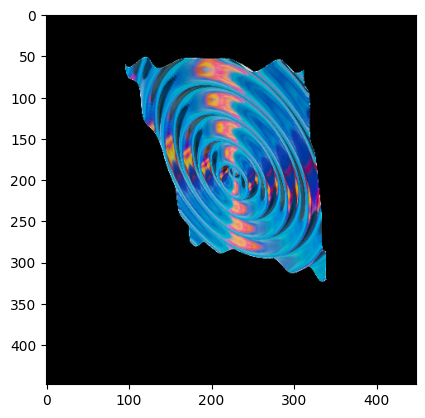

In [34]:
plt.imshow(imgs[0])


In [9]:
X_train = ds.map(lambda x : x/255).batch(16).prefetch(tf.data.AUTOTUNE)

In [6]:
from keras.layers import Lambda
from keras.models import Model
from keras.losses import binary_crossentropy
from keras.layers import Layer

In [7]:
import tensorflow as tf
class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [8]:
latent_dim = 200


input_image = Input(shape=(448, 448, 3))

# rescale_layer = Rescaling(scale=(1./255))(input_image)

x = Conv2D(16, (3, 3), padding='same', activation="relu")(input_image)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
    
x = Conv2D(32, (3, 3), padding='same', activation="relu")(input_image)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), padding='same', activation="relu")(x)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), padding='same', activation="relu")(x)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(256, (3, 3), padding='same', activation="relu")(x)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
encoder_output = Dense(latent_dim, activation="relu")(x)

z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = tf.keras.layers.Dense(latent_dim, name="z_log_var")(x)

z = Sampling()([z_mean, z_log_var])
encoder = tf.keras.Model(input_image, [z_mean, z_log_var, z], name="encoder")

encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 448, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 448, 448, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 224, 224, 32  0          ['conv2d_1[0][0]']               
                                )                                                           

In [9]:
latent_inputs = tf.keras.Input(shape=(latent_dim,))  
x = Dense(7*7*128, activation='tanh')(latent_inputs)
x = Reshape((7, 7, 128))(x)

x = Conv2DTranspose(256, (3, 3), strides=2, padding='same', activation="relu")(x)
x = Conv2DTranspose(256, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(256, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(256, (3, 3), strides=1, padding='same', activation="relu")(x)

x = Conv2DTranspose(128, (3, 3), strides=2, padding='same', activation="relu")(x)
x = Conv2DTranspose(128, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(128, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(128, (3, 3), strides=1, padding='same', activation="relu")(x)

x = Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation="relu")(x)
x = Conv2DTranspose(64, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(64, (3, 3), strides=1, padding='same', activation="relu")(x)

x = Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation="relu")(x)
x = Conv2DTranspose(32, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(32, (3, 3), strides=1, padding='same', activation="relu")(x)

x = Conv2DTranspose(16, (3, 3), strides=2, padding='same', activation="relu")(x)
x = Conv2DTranspose(16, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(16, (3, 3), strides=1, padding='same', activation="relu")(x)

# x = Conv2DTranspose(8, (3, 3), strides=2, padding='same', activation="relu")(x)
# x = Conv2DTranspose(8, (3, 3), strides=1, padding='same', activation="relu")(x)
# x = Conv2DTranspose(8, (3, 3), strides=1, padding='same', activation="relu")(x)


    
decoder_output = Conv2DTranspose(3, (3, 3), strides=2, padding='same', activation='sigmoid')(x)
    
decoder = Model(inputs=latent_inputs, outputs=decoder_output, name="decoder")
decoder.summary()
    

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 dense_1 (Dense)             (None, 6272)              1260672   
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 256)      295168    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 14, 14, 256)      590080    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 14, 14, 256)      5900

In [10]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [16]:
ds

<MapDataset element_spec=TensorSpec(shape=(None, 448, 448, 3), dtype=tf.float32, name=None)>

In [28]:
#next_images = ds.as_numpy_iterator().__next__()

In [29]:
#vae.decoder(vae.encoder(next_images[0].reshape(-1,448,448,3))[0])

In [15]:
class CallbackSaveModel(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch > 0 and epoch % 10 == 0:
            self.model.save_weights(f'../saved_models/vae_complex_model_{50 + epoch}')

cb_save_model = CallbackSaveModel()

In [11]:
vae = VAE(encoder, decoder)
vae.load_weights('../saved_models/vae_complex_model_40')

In [17]:
vae.compile(optimizer=tf.keras.optimizers.Adam())

In [18]:
#vae.load_weights('model_10')
vae.fit(ds, epochs=200, callbacks=[cb_save_model], batch_size=16)

Epoch 1/200
148/148 [==============================] - 331s 2s/step - loss: 20027.9780 - reconstruction_loss: 19882.0078 - kl_loss: 250.2534
Epoch 2/200
148/148 [==============================] - 333s 2s/step - loss: 20264.5574 - reconstruction_loss: 19862.8594 - kl_loss: 249.6271
Epoch 3/200
148/148 [==============================] - 320s 2s/step - loss: 20805.9802 - reconstruction_loss: 20620.0215 - kl_loss: 342.5296
Epoch 4/200
148/148 [==============================] - 305s 2s/step - loss: 20331.8582 - reconstruction_loss: 19907.0566 - kl_loss: 270.2671
Epoch 5/200
148/148 [==============================] - 298s 2s/step - loss: 20170.6967 - reconstruction_loss: 19769.5879 - kl_loss: 251.1910
Epoch 6/200
148/148 [==============================] - 300s 2s/step - loss: 20158.8028 - reconstruction_loss: 19688.4023 - kl_loss: 248.9523
Epoch 7/200
148/148 [==============================] - 297s 2s/step - loss: 19950.1143 - reconstruction_loss: 19689.8691 - kl_loss: 246.8169
Epoch 8/200
1

In [20]:
vae.save_weights('../saved_models/vae_complex_model_e250')

In [51]:
#vae.load_weights('save_model_test2')load_weights

In [ ]:
#vae.fit

In [ ]:
#prediction = vae.predict(ds, verbose=0)

# Original Image

In [21]:
plt.imshow(imgs[5])

NameError: name 'imgs' is not defined

# VAE reconstructed image

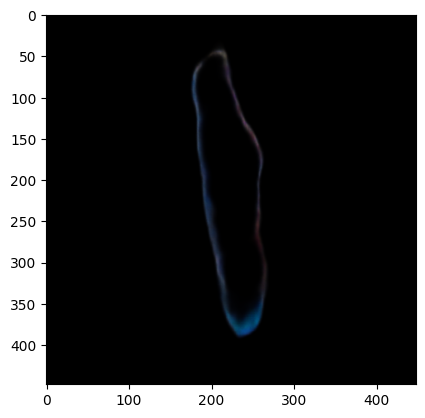

In [35]:
encoded_image = vae.encoder(imgs[5].reshape(-1,448,448,3))
decoded_image = vae.decoder(encoded_image[0])
plt.imshow((decoded_image.numpy().reshape(448,448,3) * 255).astype(np.uint8))

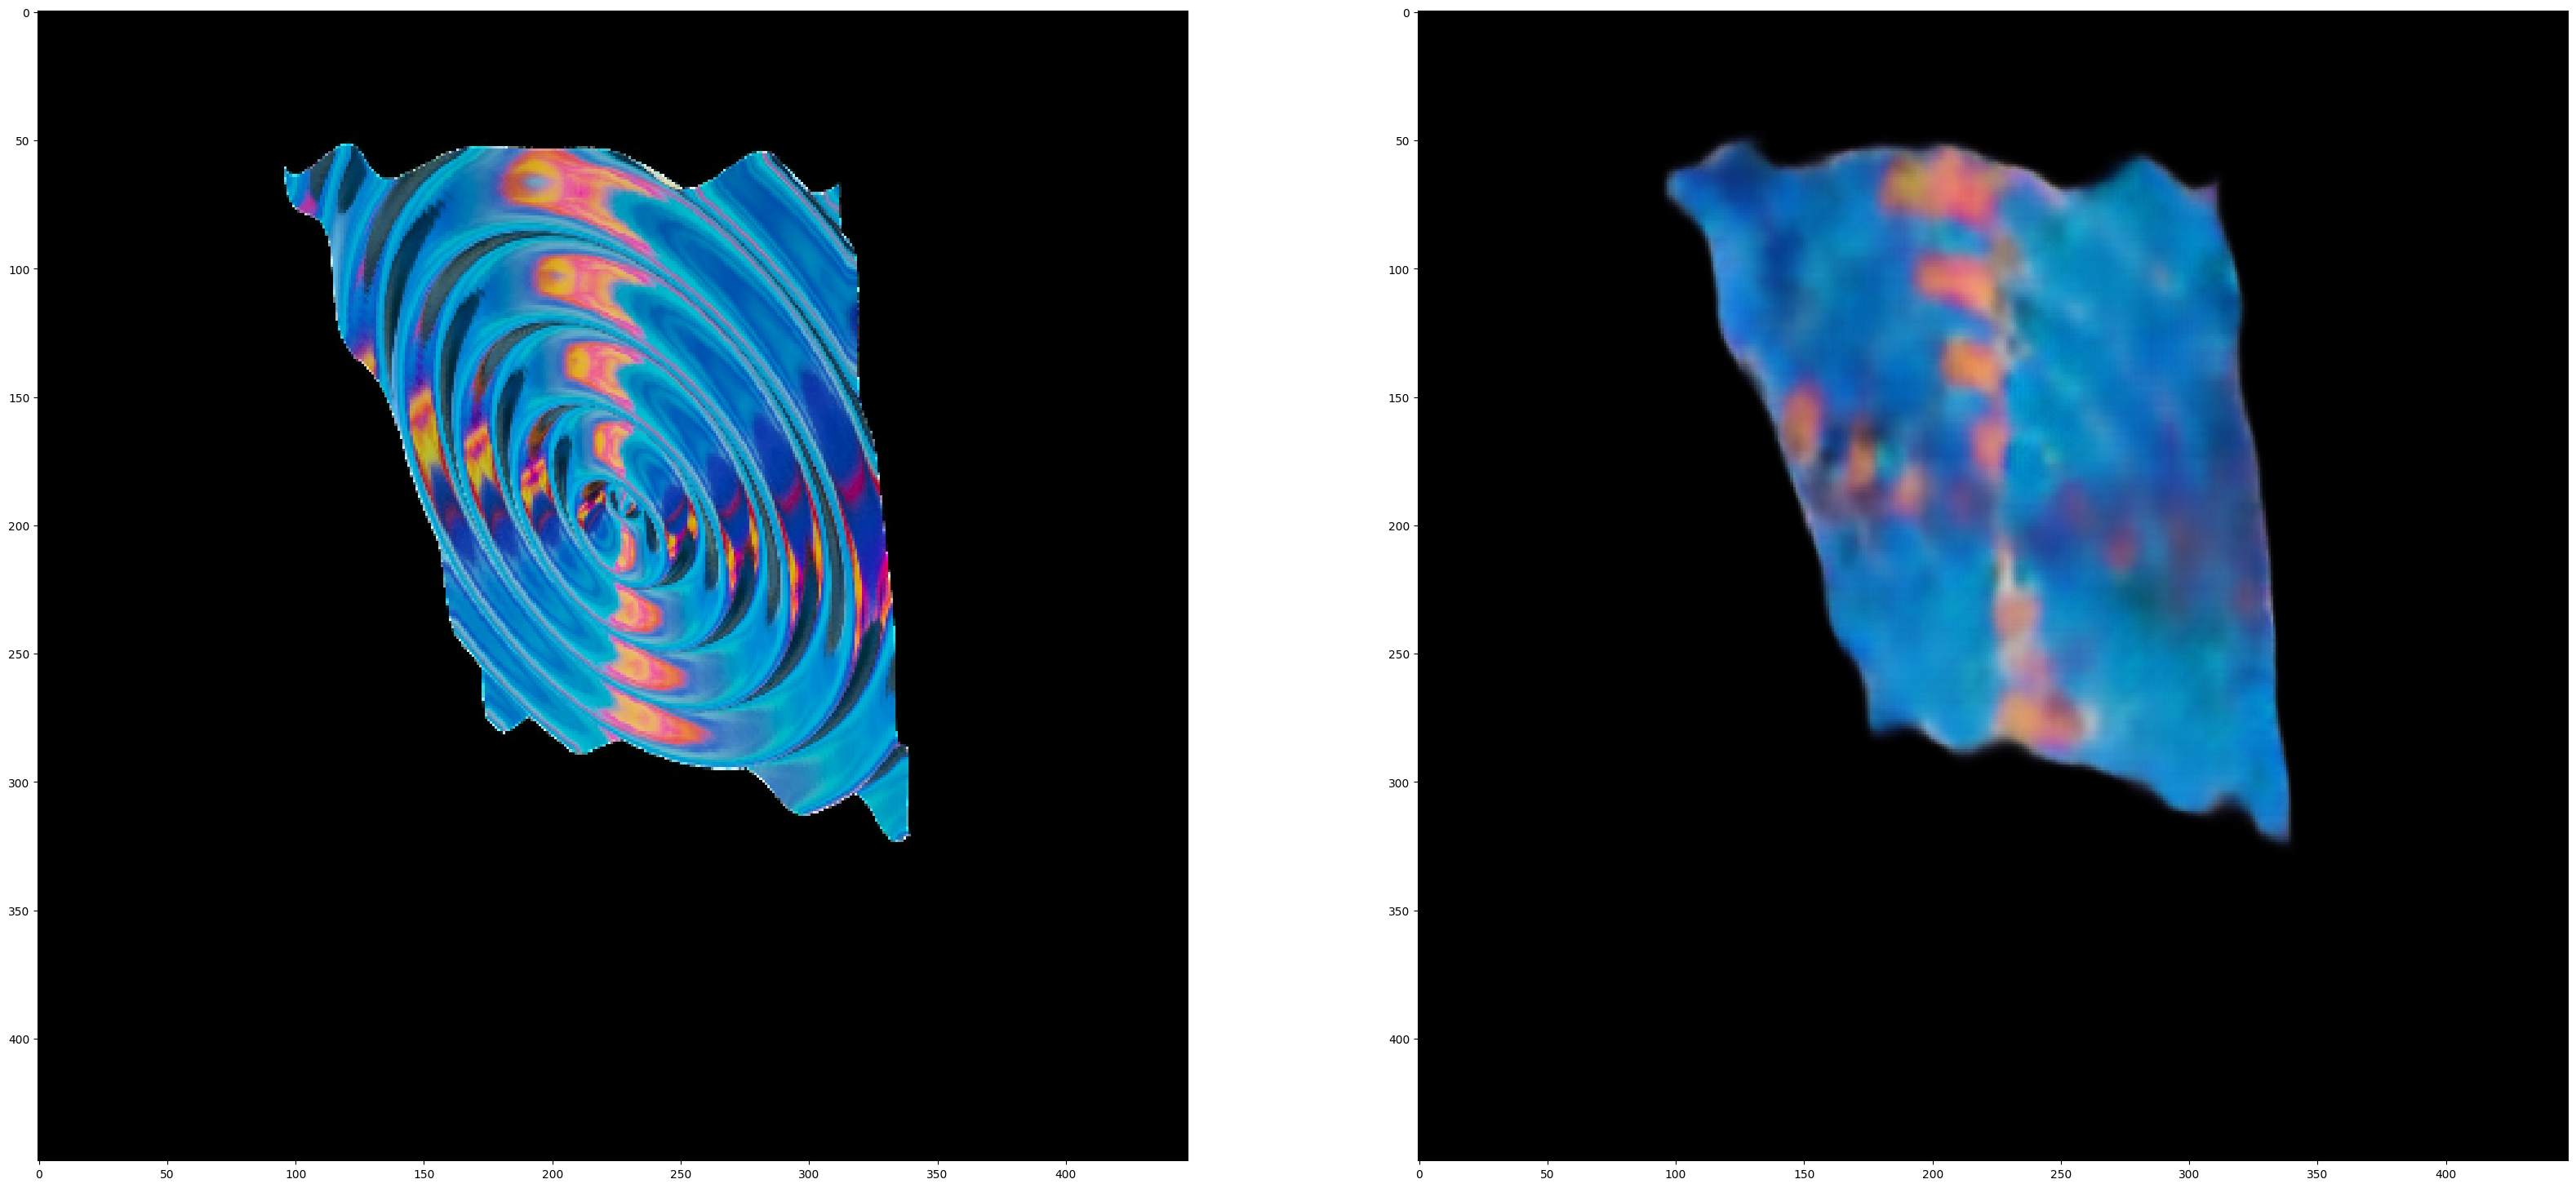

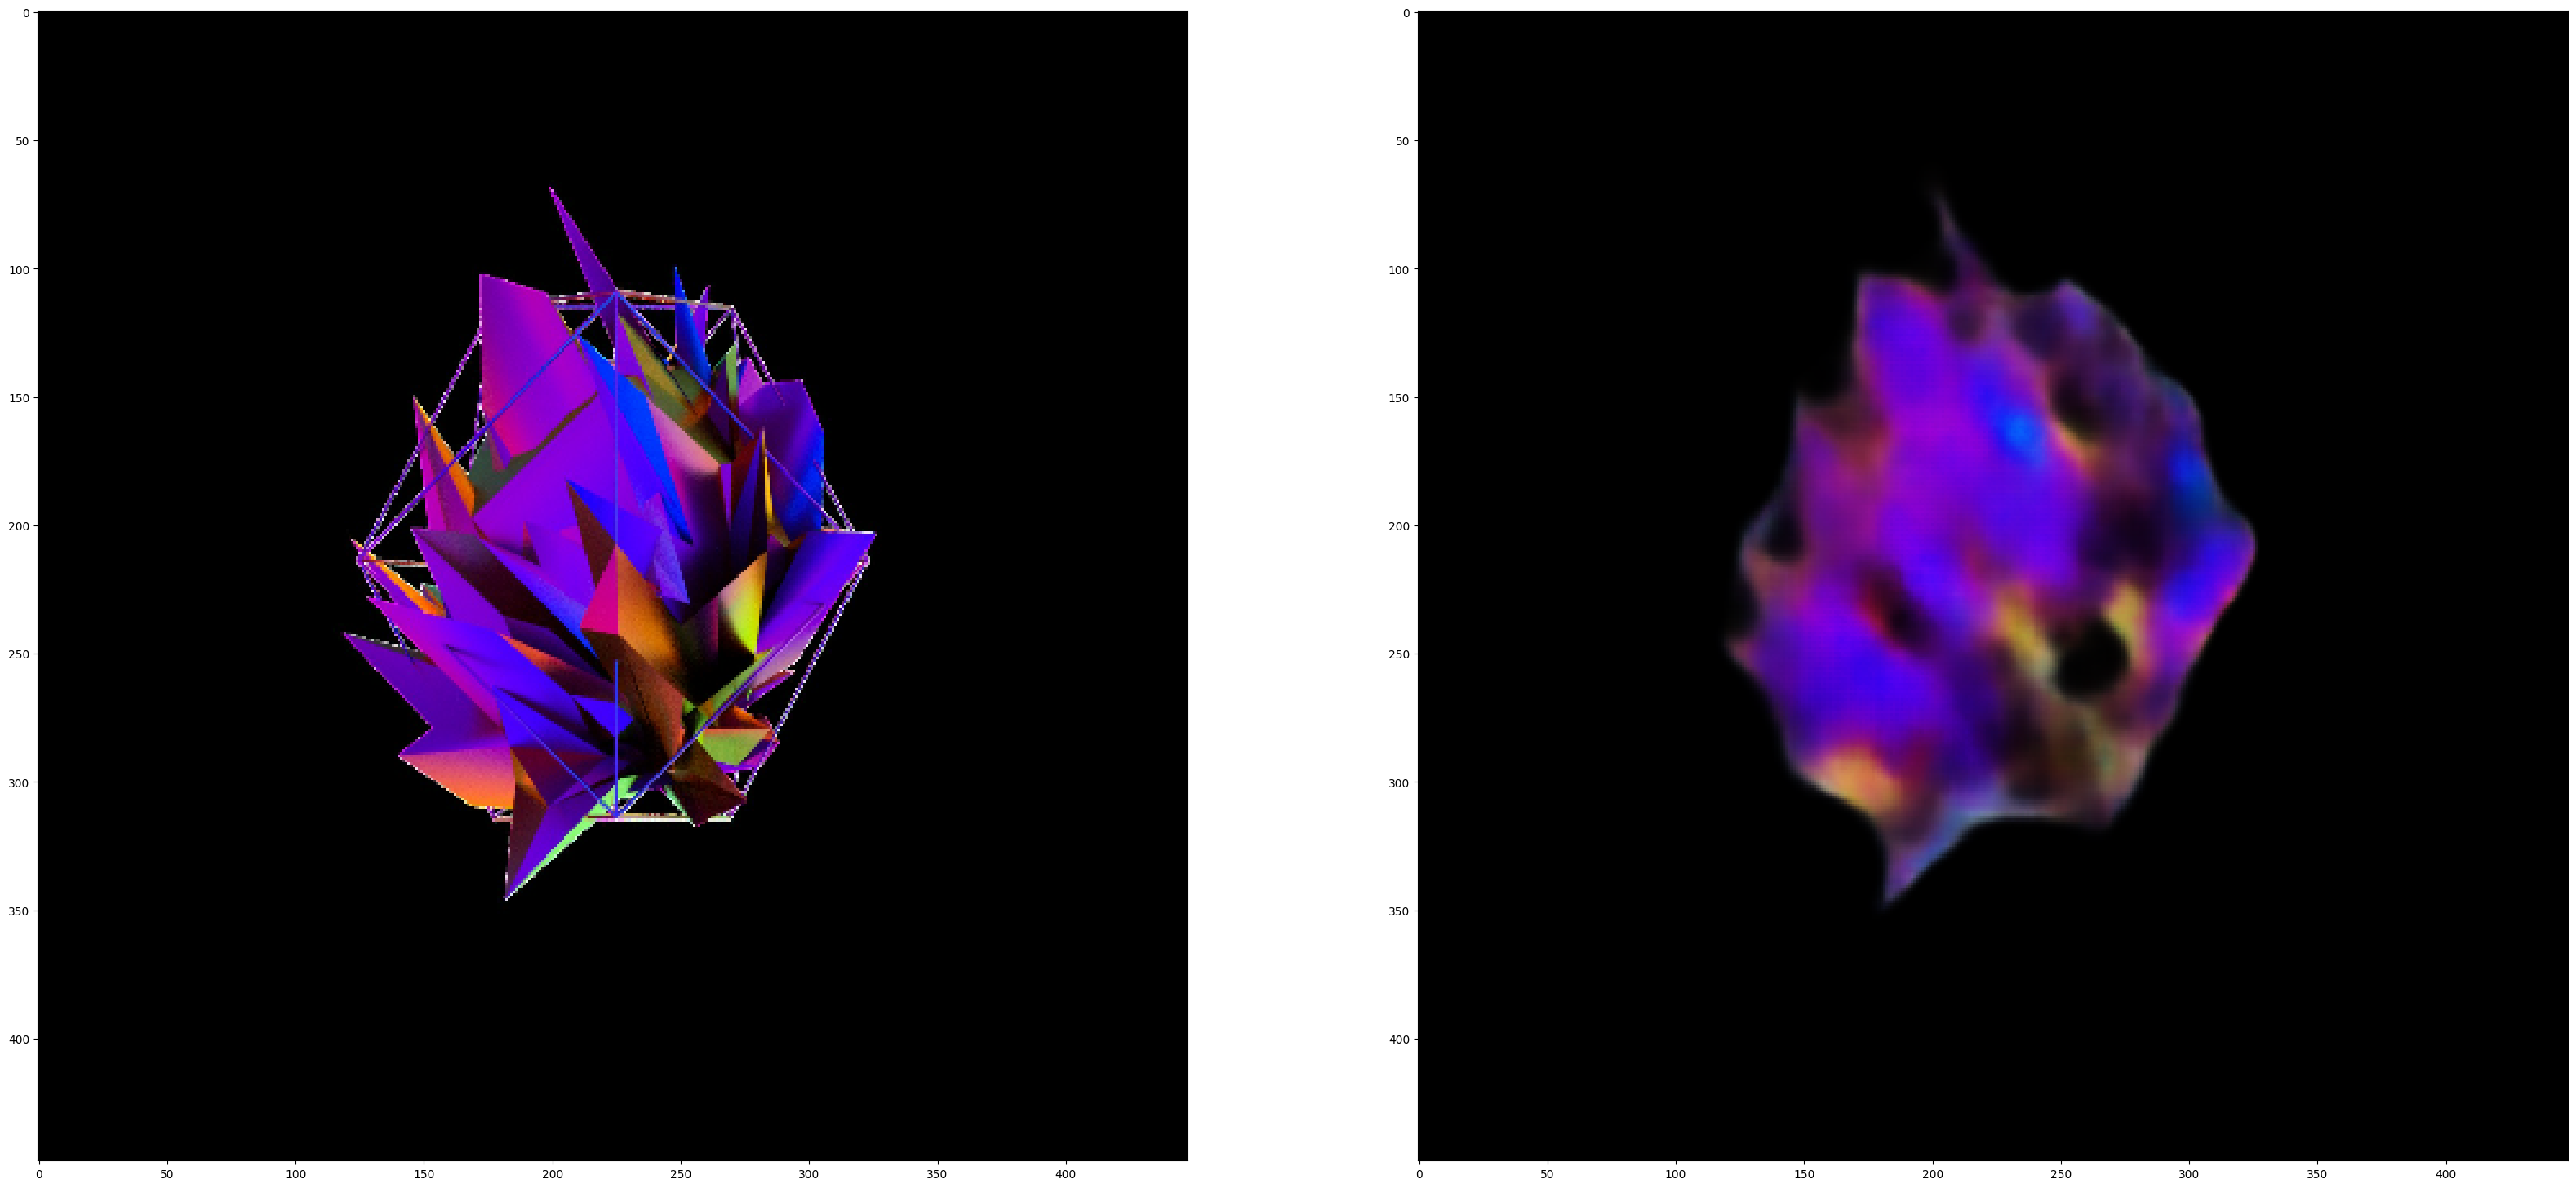

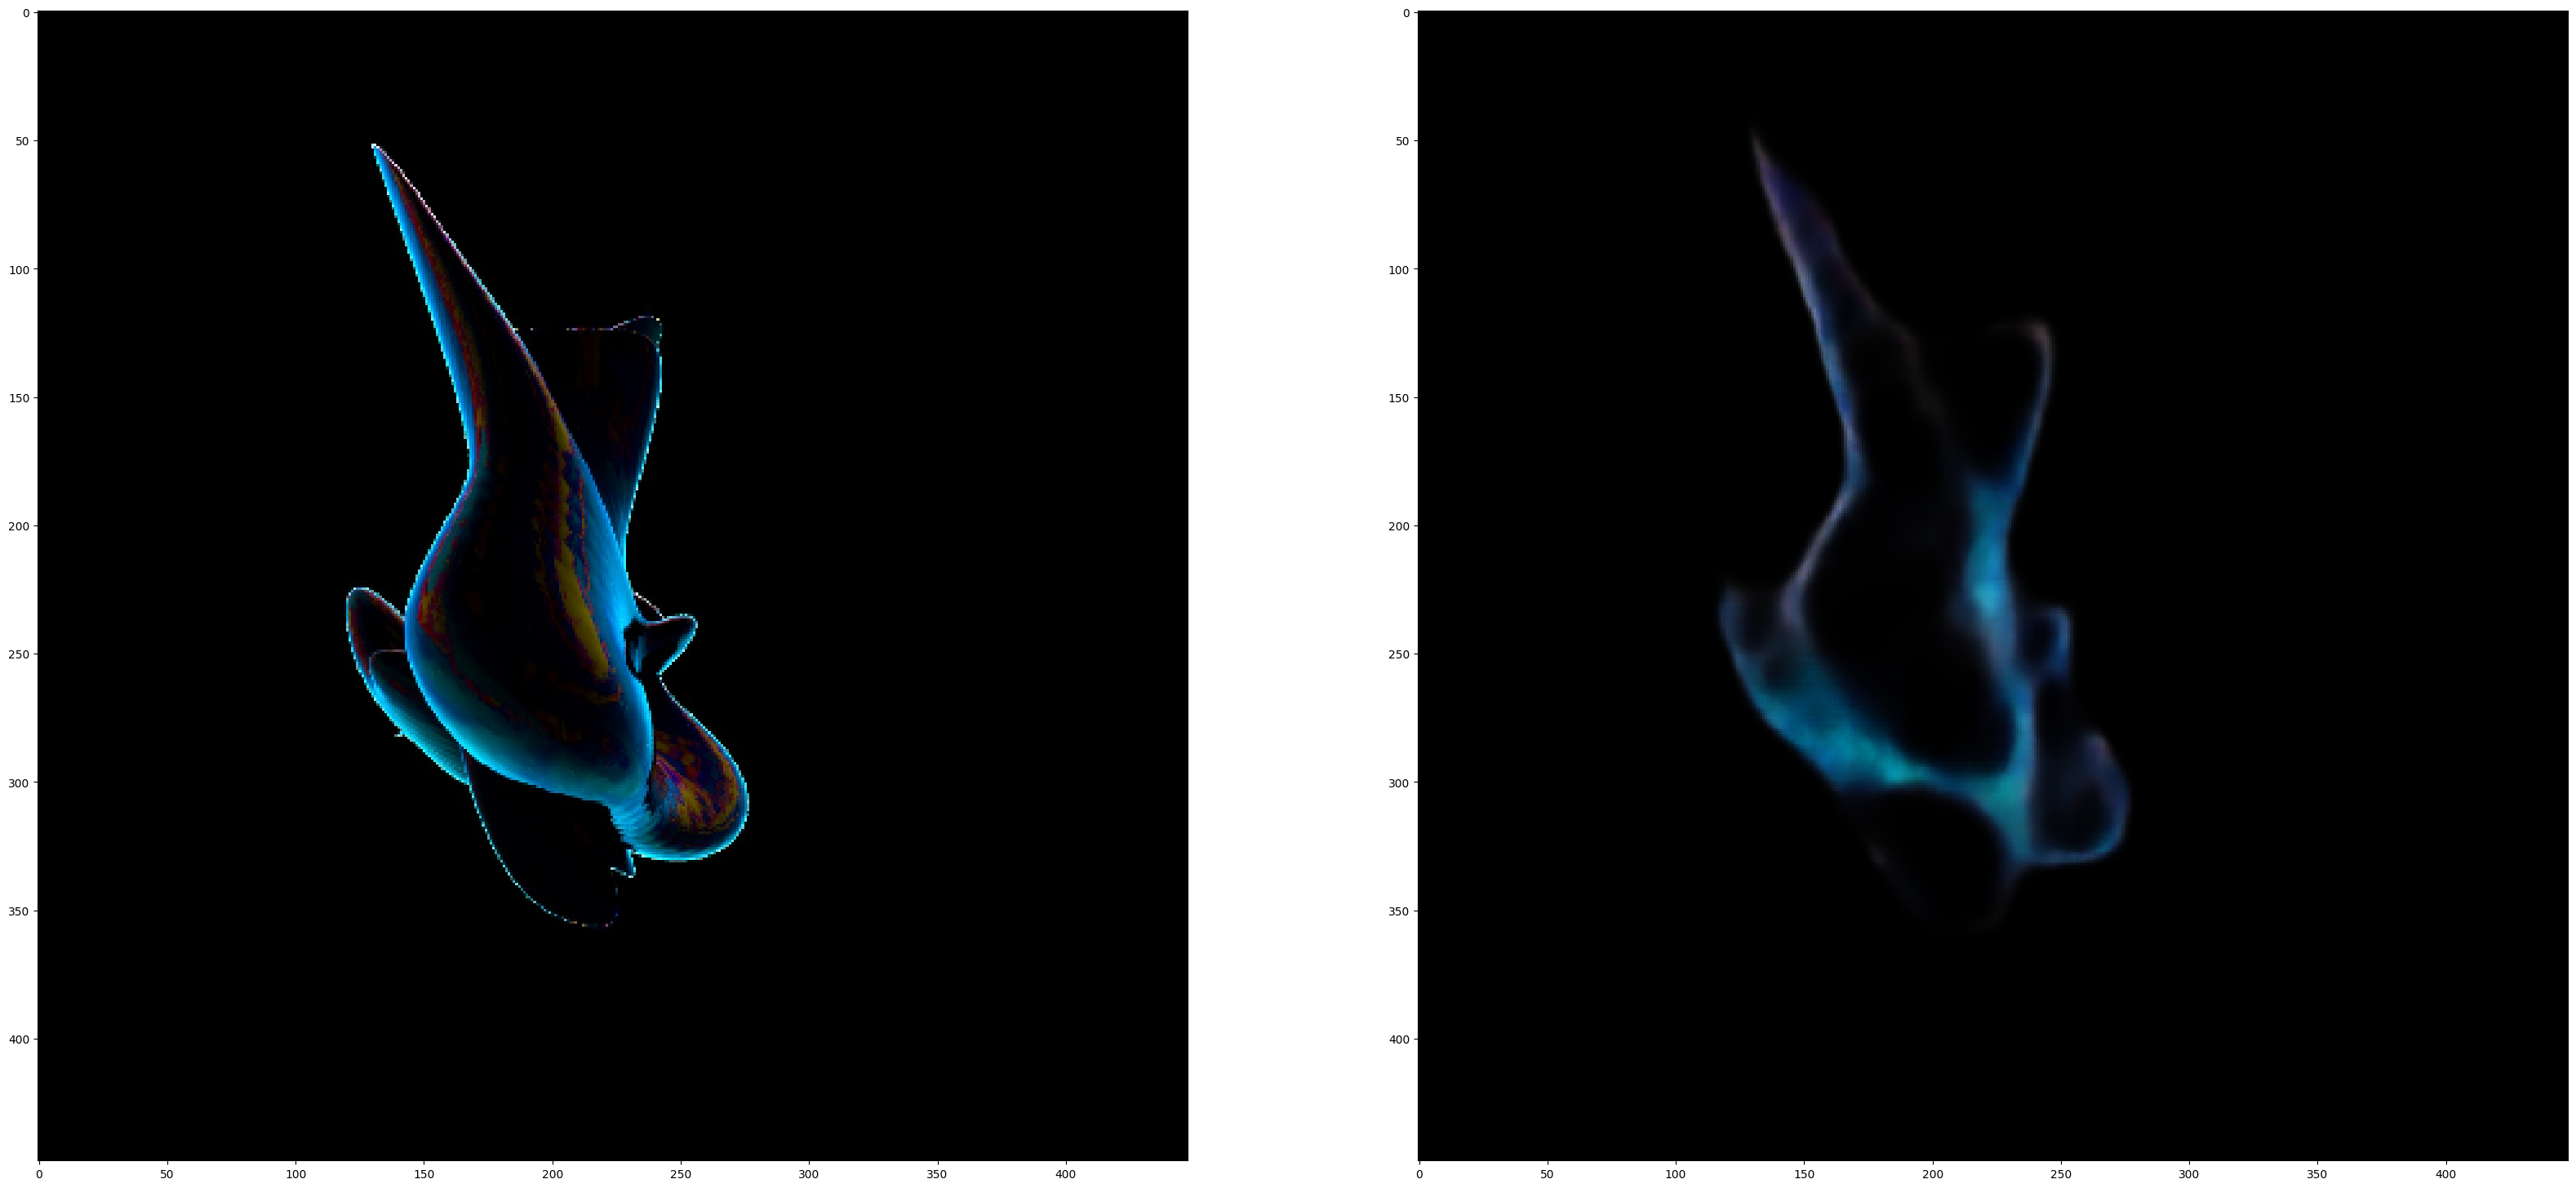

In [36]:
for i in range(3):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,20))
    encoded_image = vae.encoder(imgs[i].reshape(-1,448,448,3))
    decoded_image = vae.decoder(encoded_image[0])
    ax2.imshow((decoded_image.numpy().reshape(448,448,3) * 255).astype(np.uint8))
    ax1.imshow(imgs[i])